<a href="https://colab.research.google.com/github/Untick/IrisID_gr2/blob/Ruslan-Kuzminov-folder/Ruslan-Kuzminov-folder/identification_2_week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Идентификация по сетчатке

## **2 неделя**

**Задачи:**
- аугментация данных
- получение модели сети первой точности

### Подключение библиотек

In [1]:
# импортируем необходимые для работы библиотеки

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

import os
import gdown

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, SpatialDropout2D, BatchNormalization, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

import random
import math

from tqdm.notebook import tqdm as tq

from sklearn.model_selection import train_test_split

from google.colab import drive

### Загрузка данных

In [2]:
# подключаем google drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# проверяем содержимое папки

IMAGE_PATH = '/content/drive/MyDrive/Colab Notebooks/educations/internships/images'
IMAGE_FILES = sorted(os.listdir(IMAGE_PATH))
IMAGE_FILES[:10]

['001L_1.png',
 '001L_2.png',
 '001L_3.png',
 '001R_1.png',
 '001R_2.png',
 '001R_3.png',
 '002L_1.png',
 '002L_2.png',
 '002L_3.png',
 '002R_1.png']

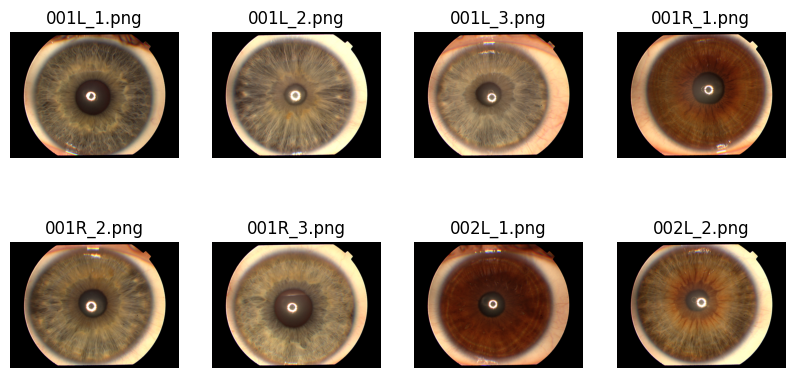

In [4]:
# выводим серию случайных изображений на экран

fig = plt.figure(figsize=(10,5))

for i in range(len(IMAGE_FILES)):
    dirs_path = f'{IMAGE_PATH}/'
    img_path = dirs_path + random.choice(os.listdir(dirs_path))
    ax = fig.add_subplot(2, 4, i + 1)
    ax.set_title(IMAGE_FILES[i])
    ax.imshow(Image.open(img_path))
    ax.axis('off')
    if i == 7: # остановить добавление изображений после 8
        break

plt.show()

In [5]:
# формируем списки для картинок и меток
labels = []
full_names = []
    
# Цикл по всем файлам в текущей директории
for files in IMAGE_FILES:
  # Чтение изображения
  image = Image.open(os.path.join(IMAGE_PATH, files))
  # Добавление метки в список меток текущей папки
  label = os.path.splitext(files)[0]  # Получаем имя файла без расширения
  full_names.append(label)
  label = label[:-2]# модифицируем имя файла
# label = label.replace('R', '1').replace('L', '0') # заменяем для последующей работы с классами
  labels.append(label)

# Вывод количества изображений и меток
print(f'Найдено {len(os.listdir(IMAGE_PATH))} изображений, {len(labels)} меток и {len(full_names)} названий')

# Вывод размера изображения
image = Image.open(os.path.join(IMAGE_PATH, os.listdir(IMAGE_PATH)[0]))
img_size = image.size
print(f'Размер изображения: {img_size}')

Найдено 384 изображений, 384 меток и 384 названий
Размер изображения: (768, 576)


In [6]:
# формируем список классов

CLASSES = sorted(list(set(labels)))

print(f'Пример названий классов: {CLASSES[0:5]}')

Пример названий классов: ['001L', '001R', '002L', '002R', '003L']


In [7]:
# создаем список классов для подмены

CLASSES_NEW = np.array(range(1, len(CLASSES)+1))

# заменяем значения меток на новые классы

labels_changed = np.where(np.isin(labels, CLASSES), CLASSES_NEW[np.searchsorted(CLASSES, labels)], labels)

# выводим результаты

print("Список классов: ", CLASSES[0:10])
print("Массив меток: ", labels[0:10])
print("Измененный массив меток: ", labels_changed[0:10])
print("Количество классов: ", len(CLASSES_NEW))

Список классов:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Массив меток:  ['001L', '001L', '001L', '001R', '001R', '001R', '002L', '002L', '002L', '002R']
Измененный массив меток:  ['1' '1' '1' '2' '2' '2' '3' '3' '3' '4']
Количество классов:  128


### Аугментируем изображения

#### Функция аугментации

In [8]:
# подготовка функции аугментации

def augment_image(img,                    # Изображение для аугментации
                  ang=8,                  # Максимальный угол поворота
                  f_x=0.,                 # Максимальная подрезка по ширине
                  f_y=0.2,                # Максимальная подрезка по высоте
                  level_contr=0.3,        # Максимальное отклонение коэффициента контраста от нормы
                  level_brght=0.3):       # Максимальное отклонение коэффициента яркости от нормы


    # Функция нахождения ширины и высоты прямоугольника наибольшей площади 
    # после поворота заданного прямоугольника на угол в градусах

    def rotated_rect(w, h, angle):
        angle = math.radians(angle)
        width_is_longer = w >= h
        side_long, side_short = (w,h) if width_is_longer else (h,w)

        sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
        if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
            x = 0.5 * side_short
            wr, hr = (x/sin_a, x/cos_a) if width_is_longer else (x/cos_a, x/sin_a)
        else:
            cos_2a = cos_a*cos_a - sin_a*sin_a
            wr, hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a

        return wr, hr


    # Функция случайной обрезки

    def random_crop(x,                    # Подаваемое изображение
                    f_x=f_x,              # Предел обрезки справа и слева (в масштабе ширины)
                    f_y=f_x               # Предел обрезки сверху и снизу (в масштабе высоты)
                    ):
        
        # Получение левой и правой границ обрезки
        left = x.width * random.random() * f_x
        right = x.width * (1. - random.random() * f_x) - 1.

        # Получение верхней и нижней границ обрезки
        upper = x.height * random.random() * f_y
        lower = x.height * (1. - random.random() * f_y) - 1.

        return x.crop((left, upper, right, lower))


    # Функция случайного поворота

    def random_rot(x,                     # Подаваемое изображение
                   ang=ang                # Максимальный угол поворота
                   ):

        # Случайное значение угла в диапазоне [-ang, ang]
        a = random.uniform(-1., 1.) * ang

        # Вращение картинки с расширением рамки
        r = x.rotate(a, expand=True)

        # Вычисление размеров прямоугольника обрезки максимальной площади 
        # для размеров исходной картинки и угла поворота в градусах
        crop_w, crop_h = rotated_rect(x.width, x.height, a)

        # Обрезка повернутого изображения и возврат результата
        w, h = r.size                   
        return r.crop(((w - crop_w)*0.5, (h - crop_h)*0.5,
                       (w + crop_w)*0.5, (h + crop_h)*0.5))
    

    # Функция отражения

    def trans_img(x):
        return x.transpose(Image.FLIP_LEFT_RIGHT)
    
    
    # Функция случайного изменения контрастности

    def random_contrast(x,                   # Подаваемое изображение
                        level=level_contr    # Максимальное отклонение коэффициента контраста от нормы - число от 0. до 1.
                        ):
    
        enh = ImageEnhance.Contrast(x)       # Создание экземпляра класса Contrast
        factor = random.uniform(1. - level, 
                                1. + level)  # Cлучайный коэффициент контраста из указанного интервала 
        
        return enh.enhance(factor)           # Изменение коэффициента контраста



    # Функция случайного изменения яркости

    def random_brightness(x,                 # Подаваемое изображение
                        level=level_brght    # Максимальное отклонение коэффициента яркости от нормы - число от 0. до 1.
                        ):
    
        enh = ImageEnhance.Brightness(x)     # Создание экземпляра класса Brightness
        factor = random.uniform(1. - level, 
                                1. + level)  # Cлучайный коэффициент контраста из указанного интервала 
        
        return enh.enhance(factor)           # Изменение коэффициента яркости


    # Тело основной функции
    
    # Cоздание списка модификаций
    mod_oper = [random_rot, 
                random_crop,
                trans_img, 
                random_contrast,
                random_brightness]

    # Cлучайное количество изменений из списка; минимум одно изменение
    mod_count = random.randrange(len(mod_oper) + 1)

    # Случайный отбор индексов изменений в количестве mod_count без повторений
    mod_list = random.sample(range(len(mod_oper)), mod_count)

    # Применение модификаций по индексам из mod_list
    for mod_index in mod_list:  
        img = mod_oper[mod_index](img)

    # Возврат результата
    return img

In [9]:
# подготовка функции сравнения оригинального изображения с измененным

def show_image_pair(img1, img2):
    # Cоздание полотна для рисования двух изображений
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Исходное изображение 
    axs[0].imshow(img1)
    axs[0].axis('off')

    # Модифицированное изображение 
    axs[1].imshow(img2)
    axs[1].axis('off')

    # Вывод изображений
    plt.show()  

In [10]:
# Создание генератора изображений с аугментацией
#data_generator = ImageDataGenerator(
#    rescale=1./255,  # Нормализация значений пикселей
#    rotation_range=10,  # Случайные повороты изображения
#    width_shift_range=0.1,  # Случайное смещение по горизонтали
#    height_shift_range=0.1,  # Случайное смещение по вертикали
#    shear_range=0.1,  # Случайные сдвиги
#    zoom_range=0.1,  # Случайное увеличение масштаба
#    horizontal_flip=True,  # Отражение изображения по горизонтали
#    validation_split=0.2  # Доля изображений для валидации
#)

#### Аугментация

In [11]:
# Применение аугментаций
labels_new = []

num_augment = 20 # количество аугментаций изображения

# новый путь для сохранения изображений
IMAGE_PATH_AUG = '/content/drive/MyDrive/Colab Notebooks/educations/internships/'
NEW_IMAGE_PATH = os.path.join(IMAGE_PATH_AUG, 'images_new')

# создание новой папки, если ее не существует
if not os.path.exists(NEW_IMAGE_PATH):
    os.makedirs(NEW_IMAGE_PATH)

for i in tq(range(len(full_names))):

    for _ in range(num_augment):
        img_new = augment_image(Image.open(os.path.join(IMAGE_PATH, f'{full_names[i]}.png')))
        # новый путь для сохранения изображения
        new_path = os.path.join(NEW_IMAGE_PATH, f'{full_names[i]}_{_}.png')
        # Сохранение изображения в новой папке
        img_new.save(new_path)
        labels_new.append(labels_changed[i])

print(f'Количество изображений: {len(os.listdir(NEW_IMAGE_PATH))} и меток: {len(labels_new)} после аугментации')

  0%|          | 0/384 [00:00<?, ?it/s]

Количество изображений: 7680 и меток: 7680 после аугментации


In [12]:
# получаем список индексов аугментированных изображений

class_name = random.choice([str(x) for x in CLASSES_NEW]) # выбираем случайный класс

indices = [i for i, x in enumerate(labels_new) if x == class_name] # получаем список индексов аугментированных изображений

print(f'Индексы изображений для 3-х изображений участника: \n {indices}')
len(indices[:30])

Индексы изображений для 3-х изображений участника: 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


30

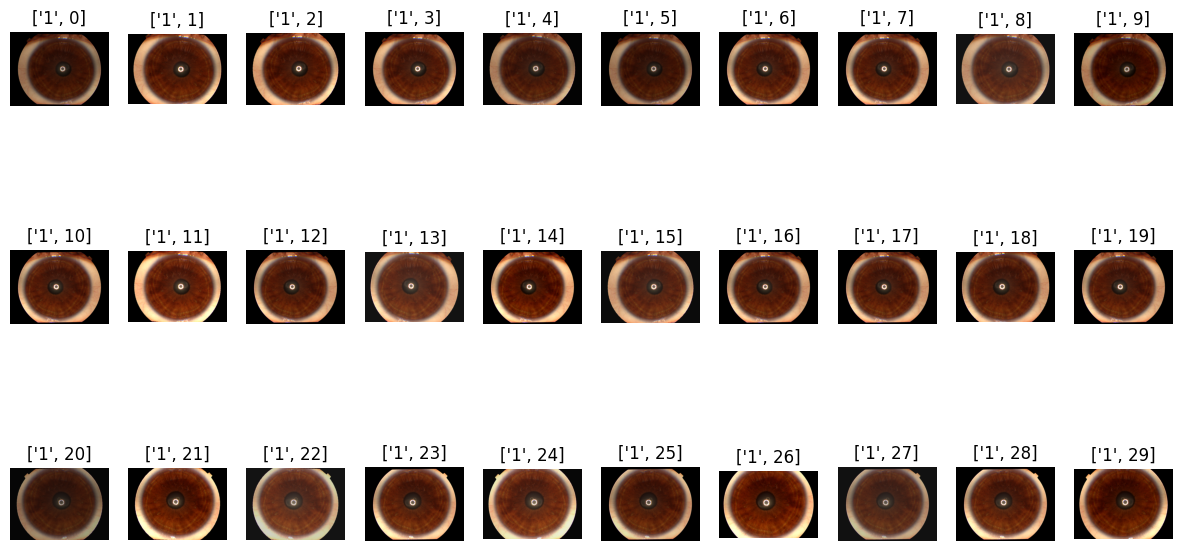

In [13]:
# посмотрим на сами изображения

fig = plt.figure(figsize=(15,8))

for i in range(len(indices[:30])):
  ind = indices[i]
  for j, filename in enumerate(os.listdir(NEW_IMAGE_PATH)):
    if j == ind:
      image_path = os.path.join(NEW_IMAGE_PATH, filename)
      image = Image.open(image_path)
      label = labels_new[indices[i]]

      image_array = np.asarray(image)

  ax = fig.add_subplot(3, 10, i+1)
  ax.set_title([label, ind])
  ax.imshow(image_array)
  ax.axis('off')

plt.show()

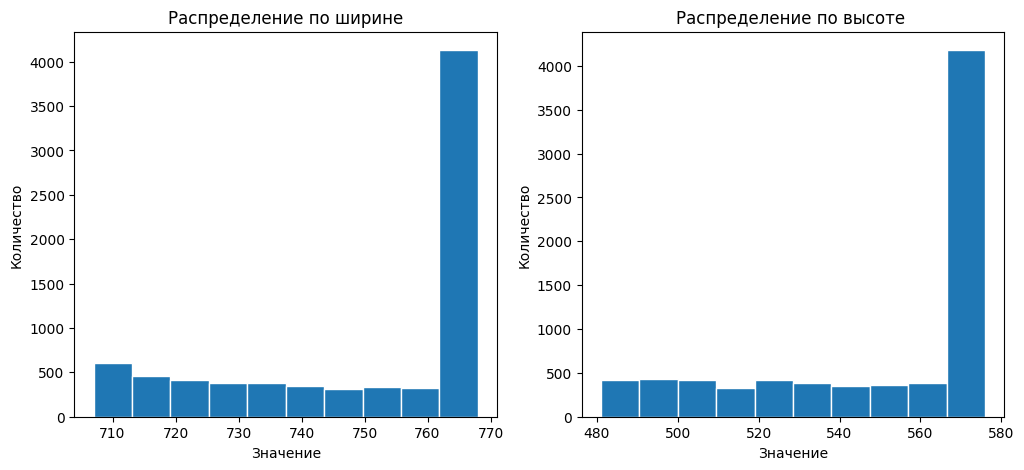

In [14]:
# проверяем размер картинок после аугментации

aug_widths = []
aug_heights = []

for filename in os.listdir(NEW_IMAGE_PATH):
    img_path = os.path.join(NEW_IMAGE_PATH, filename)
    img = Image.open(img_path)
    aug_widths.append(img.size[0])
    aug_heights.append(img.size[1])

# строим график

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(aug_widths, edgecolor='white')
plt.title('Распределение по ширине')
plt.xlabel('Значение')
plt.ylabel('Количество')


plt.subplot(122)
plt.hist(aug_heights, edgecolor='white')
plt.title('Распределение по высоте ')
plt.xlabel('Значение')
plt.ylabel('Количество')

plt.show()

In [15]:
# Задаем высоту и ширину изображений

IMG_HEIGHT = int(np.median(aug_heights) / 2.5)
IMG_WIDTH = int(np.median(aug_widths) / 2.5)

size = (IMG_HEIGHT, IMG_WIDTH)

print(f'Целевой размер изображений: {size}')

Целевой размер изображений: (230, 306)


### Подготовка датасета к обучению

In [16]:
# Пустой список для данных изображений
data_images = []                          

for filename in tq(os.listdir(NEW_IMAGE_PATH)):
    # Открытие и смена размера изображения
    img_path = os.path.join(NEW_IMAGE_PATH, filename)
    img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert('L')
    img_np = np.array(img)                # Перевод в numpy-массив
    data_images.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку

x_data = np.array(data_images).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)            # Перевод общего списка изображений в numpy-массив
y_data = np.array(labels_new)                 # Перевод общего списка меток класса в numpy-массив

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

  0%|          | 0/7680 [00:00<?, ?it/s]

В массив собрано 7680 фотографий следующей формы: (230, 306)
Общий массив данных изображений следующей формы: (7680, 230, 306, 1)
Общий массив меток классов следующей формы: (7680,)


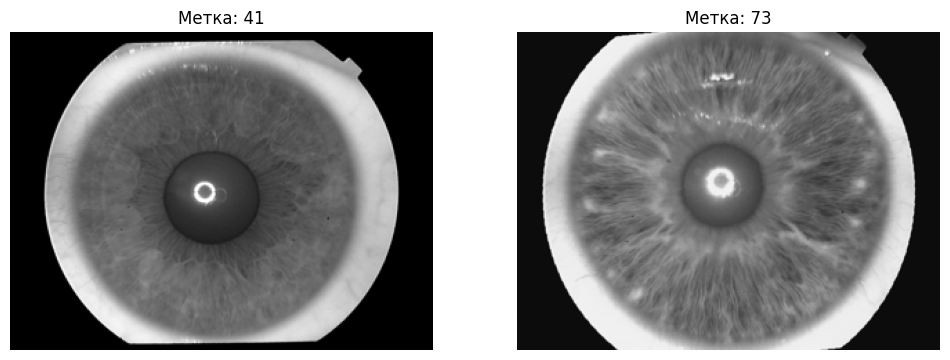

In [17]:
# Посмотрим на результат преобразований

plt.figure(figsize=(12,10))

plt.subplot(121) 
index = np.random.randint(len(x_data))
plt.imshow(x_data[index], cmap='gray')
plt.axis('off')
plt.title(f'Метка: {y_data[index]}')

plt.subplot(122)
index = np.random.randint(len(x_data))
plt.imshow(x_data[index], cmap='gray')
plt.axis('off')
plt.title(f'Метка: {y_data[index]}')
plt.show()

In [18]:
# разделяем датасет на выборки

x_train, x_full, y_train, y_full = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    shuffle=True, 
                                                    stratify=y_data)

x_valid, x_test, y_valid, y_test = train_test_split(x_full, 
                                                    y_full, 
                                                    test_size=0.5, 
                                                    random_state=42, 
                                                    shuffle=True, 
                                                    stratify=y_full)

print('Форма тренировочной выборки: ', x_train.shape, y_train.shape)
print('Форма валидационной выборки: ', x_valid.shape, y_valid.shape)
print('Форма тренировочной выборки: ', x_test.shape, y_test.shape)

Форма тренировочной выборки:  (6144, 230, 306, 1) (6144,)
Форма валидационной выборки:  (768, 230, 306, 1) (768,)
Форма тренировочной выборки:  (768, 230, 306, 1) (768,)


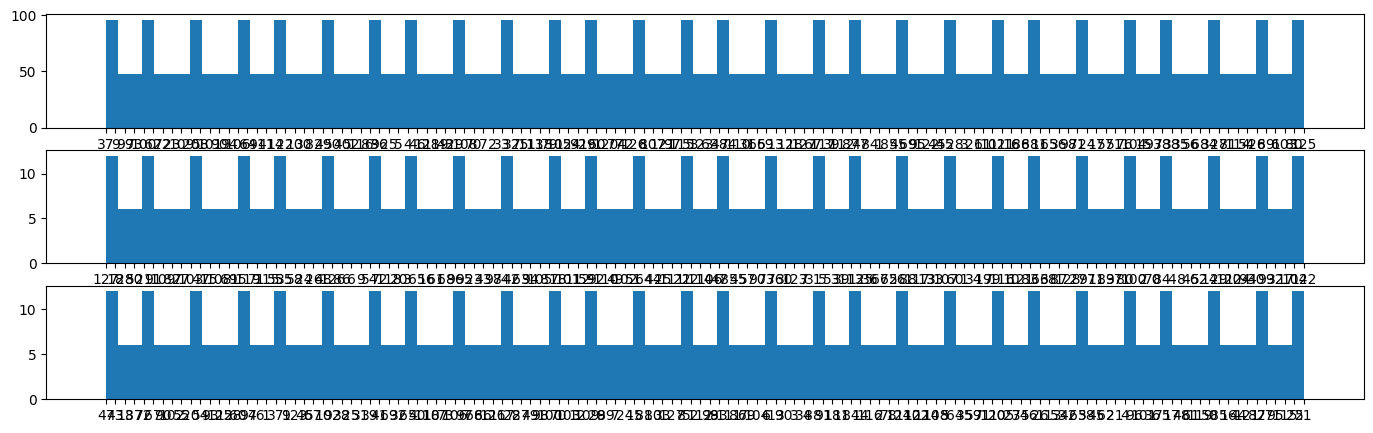

In [19]:
# смотрим на распределение классов

plt.figure(figsize=(17,5))

plt.subplot(311)
plt.hist(y_train, bins=100)

plt.subplot(312)
plt.hist(y_valid, bins=100)


plt.subplot(313)
plt.hist(y_test, bins=100)

plt.show()

In [20]:
# Нормированние массива изображений

x_train = x_train / 255.
x_valid = x_valid / 255.
x_test = x_test / 255.

In [21]:
# проводим ohe преобразование для целевой переменной

y_train = to_categorical(y_train, 129)
y_valid = to_categorical(y_valid, 129)
y_test = to_categorical(y_test, 129)

print('Количество классов:', len(y_train[0]))
print('Пример ohe: \n', y_train[0])

Количество классов: 129
Пример ohe: 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [22]:
# фиксируем форму входных данных для нейросети

input_shape = x_train.shape[1:]
input_shape

(230, 306, 1)

In [23]:
# собираем архитектуру нейросети

model = Sequential()

model.add(Conv2D(32, (2,2), input_shape=input_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (2,2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(SpatialDropout2D(0.3))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4,4)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(y_train[0]), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 230, 306, 32)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 115, 153, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 115, 153, 32)      4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 57, 76, 32)       0         
 2D)                                                             
                                                                 
 spatial_dropout2d (SpatialD  (None, 57, 76, 32)       0         
 ropout2D)                                                       
                                                        

In [24]:
# компилируем модель

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [25]:
# фиксируем гиперпараметры для обучения

params = {'batch_size' : 50,
          'epochs' : 30,
         }

In [26]:
# обучаем модель

history = model.fit(x_train, y_train, **params, validation_data=(x_valid, y_valid), verbose=1)

Epoch 1/30
123/123 [==============================] - 31s 154ms/step - loss: 4.8337 - accuracy: 0.0150 - val_loss: 4.8329 - val_accuracy: 0.0130
Epoch 2/30
123/123 [==============================] - 16s 132ms/step - loss: 3.9558 - accuracy: 0.0876 - val_loss: 3.6971 - val_accuracy: 0.1628
Epoch 3/30
123/123 [==============================] - 16s 131ms/step - loss: 2.1227 - accuracy: 0.4093 - val_loss: 1.9531 - val_accuracy: 0.4844
Epoch 4/30
123/123 [==============================] - 16s 134ms/step - loss: 0.9883 - accuracy: 0.7028 - val_loss: 0.8715 - val_accuracy: 0.7604
Epoch 5/30
123/123 [==============================] - 16s 132ms/step - loss: 0.4192 - accuracy: 0.8791 - val_loss: 0.3578 - val_accuracy: 0.9036
Epoch 6/30
123/123 [==============================] - 16s 132ms/step - loss: 0.2058 - accuracy: 0.9450 - val_loss: 0.2385 - val_accuracy: 0.9336
Epoch 7/30
123/123 [==============================] - 16s 132ms/step - loss: 0.0999 - accuracy: 0.9797 - val_loss: 0.1904 - val_ac

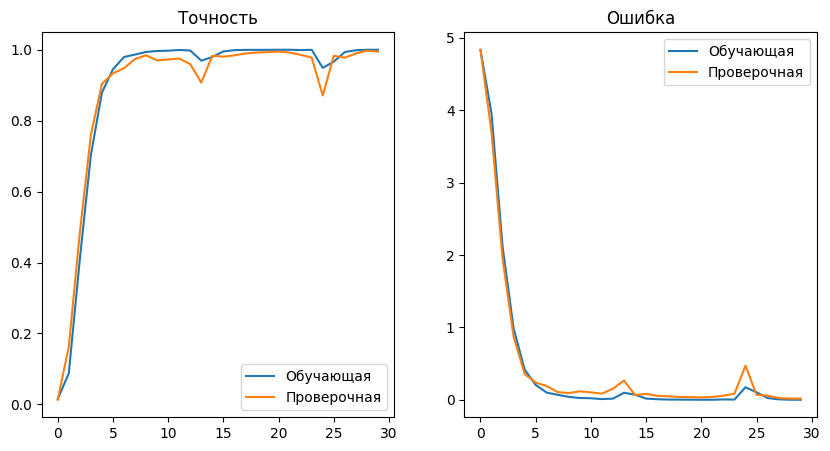

In [27]:
# строим график обучения модели

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Обучающая')
plt.plot(history.history['val_accuracy'], label='Проверочная')
plt.legend()
plt.title('Точность')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Обучающая')
plt.plot(history.history['val_loss'], label='Проверочная')
plt.legend()
plt.title('Ошибка')
plt.show()

1/1 [==============================] - 0s 407ms/step


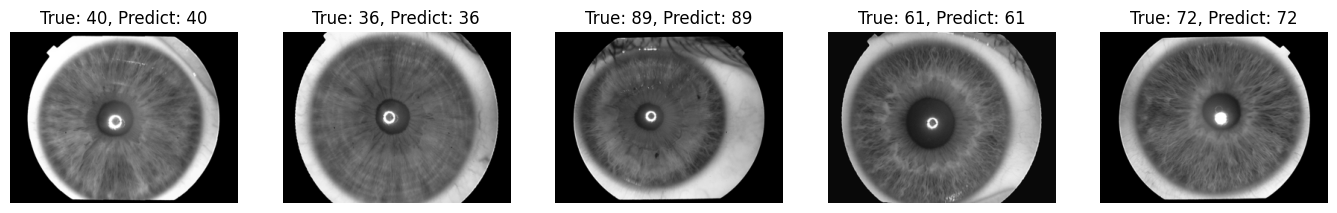

In [28]:
# Получение случайных индексов изображений
random_indices = np.random.choice(len(x_train), 5)

# Получение изображений и меток по случайным индексам
images = x_train[random_indices]
true_labels = y_train[random_indices]

# Предсказание классов для изображений
predicted_labels = model.predict(images)

# Вывод изображений и меток в одну строку
fig, axs = plt.subplots(1, 5, figsize=(17, 3))
for i in range(5):
    # Отображение изображения в серых тонах
    axs[i].imshow(images[i].reshape((IMG_HEIGHT, IMG_WIDTH)), cmap='gray')
    # Отображение меток
    axs[i].set_title(f"True: {np.argmax(true_labels[i])}, Predict: {np.argmax(predicted_labels[i])}")
    axs[i].axis('off')
plt.show()

### Проверка адекватности распознавания изображений моделью

In [29]:
x = x_train[0].reshape(1, 204,284,1)

ValueError: ignored

In [ ]:
model.layers

In [ ]:
# проверяем форму выхода первого сверточного слоя

first_conv_output = model.layers[0](x)
first_conv_output.shape

In [ ]:
# проверяем результат работы первого сверточного слоя

plt.figure(figsize=(20, 10))

for i in range(32):
  plt.subplot(4, 8, i + 1)
  plt.imshow(first_conv_output[0, : , : , i], cmap='gray')
  plt.axis('off')
plt.show()

In [ ]:
# подаем результат первого сверточного слоя во второй сверточный слой

second_conv_output = model.layers[2](first_conv_output)
second_conv_output.shape

In [ ]:
# проверяем результат работы второго сверточного слоя

plt.figure(figsize=(20, 10))

for i in range(32):
  plt.subplot(4, 8, i + 1)
  plt.imshow(second_conv_output[0, : , : , i], cmap='gray')
  plt.axis('off')
plt.show()